In [1]:
# 2번 셀: 기본 import + PaddleOCR 초기화

import cv2
import numpy as np
import pyperclip
import mss
import re
import matplotlib.pyplot as plt

from paddleocr import PaddleOCR

# 전역 OCR 엔진 (한 번만 생성)

ocr_en = PaddleOCR(use_angle_cls=False, lang="en")
ocr_kr = PaddleOCR(use_angle_cls=False, lang="korean")

print("OCR 엔진 준비 완료 (EN / KR)")





c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.
C:\Users\snk74\AppData\Local\Temp\ipykernel_18676\2002733410.py:14: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_en = PaddleOCR(use_angle_cls=False, lang="en")
c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  w

OCR 엔진 준비 완료 (EN / KR)


In [2]:
def capture_full_screen_bgr():
    import mss
    with mss.mss() as sct:
        monitor = sct.monitors[1]
        img = np.array(sct.grab(monitor))
        return cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

def select_roi(img_bgr):
    r = cv2.selectROI("Select ROI", img_bgr, False, False)
    cv2.destroyWindow("Select ROI")
    x, y, w, h = r
    if w == 0 or h == 0:
        return None
    return img_bgr[y:y+h, x:x+w]


In [ ]:


def preprocess_for_code_ocr(
    img_bgr: np.ndarray,
    scale_min_side: int = 700,     # 이보다 작으면 확대
    scale_up: float = 2.0,         # 확대 배율
    use_clahe: bool = True,        # 국소 대비 강화
    use_unsharp: bool = True,      # 샤프닝
    binarize: str = "otsu",        # "none" | "otsu" | "adaptive"
    invert_auto: bool = True,      # 다크테마 자동 반전
    denoise: bool = True,          # 약한 노이즈 제거
) -> np.ndarray:
    """
    코드 스크린샷 OCR을 위한 전처리 함수.

    처리 순서:
    1. Grayscale
    2. 다크 테마 자동 반전
    3. 작은 이미지 확대
    4. 노이즈 제거
    5. 대비 강화 (CLAHE)
    6. 샤프닝 (Unsharp Mask)
    7. 이진화 (OTSU / Adaptive)
    8. PaddleOCR 입력용 BGR 변환

    반환값:
        PaddleOCR에 바로 넣을 수 있는 BGR 이미지 (np.ndarray)
    """

    if img_bgr is None or not isinstance(img_bgr, np.ndarray) or img_bgr.size == 0:
        raise ValueError("preprocess_for_code_ocr: 입력 이미지가 비정상입니다.")

    # 1) Grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 2) 다크테마 자동 반전
    if invert_auto:
        # 평균 밝기가 낮으면(어두우면) 반전
        if gray.mean() < 127:
            gray = cv2.bitwise_not(gray)

    # 3) 이미지 확대 (작은 글자 보정)
    h, w = gray.shape[:2]
    min_side = min(h, w)

    if min_side < scale_min_side:
        new_w = int(w * scale_up)
        new_h = int(h * scale_up)
        gray = cv2.resize(
            gray,
            (new_w, new_h),
            interpolation=cv2.INTER_CUBIC,
        )

    # 4) 노이즈 제거 (과하면 글자 뭉개질 수 있으니 약하게)
    if denoise:
        gray = cv2.fastNlMeansDenoising(
            gray,
            None,
            h=10,
            templateWindowSize=7,
            searchWindowSize=21
        )

    # 5) 대비 강화 (CLAHE)
    if use_clahe:
        clahe = cv2.createCLAHE(
            clipLimit=2.0,
            tileGridSize=(8, 8)
        )
        gray = clahe.apply(gray)

    # 6) 샤프닝 (Unsharp Mask)
    if use_unsharp:
        blur = cv2.GaussianBlur(gray, (0, 0), sigmaX=1.0)
        gray = cv2.addWeighted(
            gray, 1.6,    # 원본 가중치
            blur, -0.6,   # 블러 감산
            0
        )

    # 7) 이진화
    if binarize == "otsu":
        _, out = cv2.threshold(
            gray,
            0,
            255,
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    elif binarize == "adaptive":
        out = cv2.adaptiveThreshold(
            gray,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            31,  # block size (홀수)
            5    # C 값
        )
    else:
        out = gray

    # 8) PaddleOCR 입력용 BGR(3채널) 변환
    out_bgr = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)
    return out_bgr



In [4]:
def run_predict(ocr_engine, img_bgr):
    img_proc = preprocess_for_code_ocr(img_bgr)
    result = ocr_engine.predict(
        input=img_proc,
        use_doc_orientation_classify=False,
        use_doc_unwarping=False,
        use_textline_orientation=False,
    )
    if not result:
        return []

    r = result[0]
    data = r if hasattr(r, "get") else dict(r)

    texts = data.get("rec_texts", [])
    scores = data.get("rec_scores", [])
    if not scores or len(scores) != len(texts):
        scores = [1.0] * len(texts)

    return [t.strip() for t, s in zip(texts, scores)
            if t and t.strip() and s >= 0.35]


In [5]:


def run_predict_lines(ocr_engine, img_bgr, y_threshold=14, score_thresh=0.35):
    """
    반환: 줄 객체 리스트
    [
      {"text": "...", "x": 줄의 가장 왼쪽 x, "y": 줄 대표 y, "tokens":[(x_min,x_max,text,score),...]},
      ...
    ]
    """
    img_proc = preprocess_for_code_ocr(img_bgr)

    result = ocr_engine.predict(
        input=img_proc,
        use_doc_orientation_classify=False,
        use_doc_unwarping=False,
        use_textline_orientation=False,
    )
    if not result:
        return []

    r = result[0]
    data = r if hasattr(r, "get") else dict(r)

    texts  = data.get("rec_texts", [])
    boxes  = data.get("rec_boxes", None)
    scores = data.get("rec_scores", [])

    if not texts:
        return []

    if not scores or len(scores) != len(texts):
        scores = [1.0] * len(texts)

    # rec_boxes 없으면 들여쓰기 복원은 못 하니 x=0으로라도 반환
    if boxes is None or len(boxes) != len(texts):
        out = []
        for t, s in zip(texts, scores):
            if t and t.strip() and s >= score_thresh:
                out.append({"text": t.strip(), "x": 0.0, "y": 0.0, "tokens": []})
        return out

    items = []
    for t, b, s in zip(texts, boxes, scores):
        if not t or not t.strip():
            continue
        if s < score_thresh:
            continue
        x_min, y_min, x_max, y_max = map(float, b)
        items.append((x_min, y_min, x_max, y_max, t.strip(), float(s)))

    if not items:
        return []

    items.sort(key=lambda it: (it[1], it[0]))

    grouped = []
    cur = []
    cur_y = None

    for it in items:
        x_min, y_min, x_max, y_max, t, s = it
        if cur_y is None:
            cur_y = y_min
            cur = [it]
            continue
        if abs(y_min - cur_y) <= y_threshold:
            cur.append(it)
        else:
            grouped.append(cur)
            cur = [it]
            cur_y = y_min

    if cur:
        grouped.append(cur)

    lines = []
    for line_items in grouped:
        line_items.sort(key=lambda it: it[0])
        line_x = min(it[0] for it in line_items)
        line_y = float(np.mean([it[1] for it in line_items]))
        line_text = " ".join(it[4] for it in line_items)
        tokens = [(it[0], it[2], it[4], it[5]) for it in line_items]
        lines.append({"text": line_text, "x": line_x, "y": line_y, "tokens": tokens})

    return lines


In [6]:
CODE_CHAR_PATTERN = re.compile(
    r"[A-Za-z0-9_\(\)\[\]\{\}\.\,\:\;\=\+\-\*/<>!\"\'`@#&|\\^~]"
)

def contains_korean(text: str) -> bool:
    if not text:
        return False
    return any('가' <= ch <= '힣' for ch in text)


def score_line_quality(line: str) -> float:
    if not line:
        return -1.0
    s = line.strip()
    if len(s) < 2:
        return -1.0
    code_chars = CODE_CHAR_PATTERN.findall(s)
    ratio = len(code_chars) / max(len(s), 1)
    if re.fullmatch(r"[\=\-\_\.]+", s):
        ratio -= 0.4
    return ratio

def merge_en_kr_lines(en_lines, kr_lines):
    """
    en_lines/kr_lines: run_predict_lines가 반환한 '줄 객체 리스트'
    """
    n = max(len(en_lines), len(kr_lines))
    merged = []

    for i in range(n):
        en = en_lines[i] if i < len(en_lines) else {"text":"", "x":0.0, "y":0.0, "tokens":[]}
        kr = kr_lines[i] if i < len(kr_lines) else {"text":"", "x":0.0, "y":0.0, "tokens":[]}

        # 한글이 포함된 줄은 KR 우선
        if contains_korean(kr["text"]):
            chosen = kr
        else:
            en_q = score_line_quality(en["text"])
            kr_q = score_line_quality(kr["text"])

            chosen = en if en_q > kr_q else kr
            if abs(en_q - kr_q) < 0.05:
                chosen = en if len(en["text"]) >= len(kr["text"]) else kr

        if chosen["text"].strip():
            merged.append(chosen)

    return merged

def estimate_space_px_from_tokens(lineobjs, fallback=12.0):
    per_char = []
    for ln in lineobjs:
        for x_min, x_max, t, s in ln.get("tokens", []):
            w = float(x_max - x_min)
            n = max(len(t), 1)
            per_char.append(w / n)

    if not per_char:
        return fallback

    med = float(np.median(per_char))
    return max(6.0, min(med, 30.0))


def restore_indentation(lineobjs, space_px=None):
    if not lineobjs:
        return []

    if space_px is None:
        space_px = estimate_space_px_from_tokens(lineobjs)

    base_x = min(ln["x"] for ln in lineobjs)

    out_lines = []
    for ln in lineobjs:
        indent_spaces = int(round((ln["x"] - base_x) / space_px))
        indent_spaces = max(0, min(indent_spaces, 80))
        out_lines.append((" " * indent_spaces) + ln["text"])

    return out_lines





In [7]:
def show_bgr(title, img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 4))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()



In [8]:
def fix_multiline_code(lines):
    """
    OCR 결과로 잘게 쪼개진 코드 줄을
    '의미상 한 줄'로 다시 합쳐주는 후처리 함수
    """
    fixed = []
    buffer = ""

    for line in lines:
        s = line.strip()
        if not s:
            continue

        if buffer:
            # 조건문이 아직 안 끝난 경우
            if (
                buffer.endswith(("if", "for", "while", "elif"))
                or (re.search(r"\b(if|for|while|elif)\b", buffer)
                    and not buffer.rstrip().endswith(":"))
            ):
                buffer += " " + s
                continue

            # 문자열이 열려 있는 경우
            if buffer.count('"') % 2 == 1 or buffer.count("'") % 2 == 1:
                buffer += " " + s
                continue

            # 한글만 있는 줄은 이전 줄과 합치기
            if re.fullmatch(r"[가-힣]+", s):
                buffer += " " + s
                continue

        if buffer:
            fixed.append(buffer)

        buffer = s

    if buffer:
        fixed.append(buffer)

    return fixed


In [ ]:
def merge_en_kr_lineobjs(en_lines, kr_lines):
    """
    en_lines / kr_lines: run_predict_lines의 반환(list of dict)
    줄 순서 기반으로 합칩니다.
    - contains_korean, score_line_quality 는 '기존에 이미 정의된 것'을 사용합니다.
    """
    n = max(len(en_lines), len(kr_lines))
    merged = []

    for i in range(n):
        en = en_lines[i] if i < len(en_lines) else {"text":"", "x":0.0, "y":0.0, "tokens":[]}
        kr = kr_lines[i] if i < len(kr_lines) else {"text":"", "x":0.0, "y":0.0, "tokens":[]}

        if contains_korean(kr["text"]):
            chosen = kr
        else:
            en_q = score_line_quality(en["text"])
            kr_q = score_line_quality(kr["text"])
            chosen = en if en_q > kr_q else kr
            if abs(en_q - kr_q) < 0.05:
                chosen = en if len(en["text"]) >= len(kr["text"]) else kr

        if chosen["text"].strip():
            merged.append(chosen)

    return merged


def estimate_space_px_from_tokens(lineobjs, fallback=12.0):
    """
    각 토큰의 박스 폭 / 글자수로 '대략 글자 폭'을 추정 → 공백 폭으로 사용.
    """
    per_char = []
    for ln in lineobjs:
        for x_min, x_max, t, s in ln.get("tokens", []):
            w = float(x_max - x_min)
            n = max(len(t), 1)
            per_char.append(w / n)

    if not per_char:
        return fallback

    med = float(np.median(per_char))
    return max(6.0, min(med, 30.0))


def restore_indentation(lineobjs, tab_size=4, space_px=None):
    """
    선택된 줄 객체들에 대해 x좌표를 기반으로 앞 공백(들여쓰기)을 복원합니다.
    """
    if not lineobjs:
        return []

    if space_px is None:
        space_px = estimate_space_px_from_tokens(lineobjs)

    base_x = min(ln["x"] for ln in lineobjs)

    out_lines = []
    for ln in lineobjs:
        indent_spaces = int(round((ln["x"] - base_x) / space_px))
        indent_spaces = max(0, min(indent_spaces, 80))
        out_lines.append((" " * indent_spaces) + ln["text"])

    return out_lines


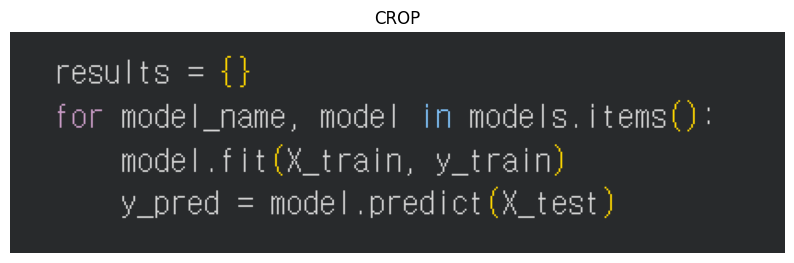

===== FINAL OCR =====
results = {}
for model_name, model in models.i tems():
model.fit(x_train, y_train)
y_pred = model.predict (x_test)
클립보드 복사 완료


In [15]:
# 1) 캡처
full_img = capture_full_screen_bgr()
crop_img = select_roi(full_img)

if crop_img is None:
    print("ROI 선택 취소")
else:
    show_bgr("CROP", crop_img)

    # 2) OCR 실행
    lines_en = run_predict_lines(ocr_en, crop_img)
    lines_kr = run_predict_lines(ocr_kr, crop_img)

    # 3) 결과 병합 (함수명 확인 필요: merge_en_kr_lineobjs 권장)
    merged_lineobjs = merge_en_kr_lineobjs(lines_en, lines_kr)

    # 4) 들여쓰기 복원 (space_px=8 등 상황에 맞게 조절)
    restored_lines = restore_indentation(merged_lineobjs, space_px=8)

    # 5) 문맥 보정 (끊긴 줄 이어붙이기)
    final_lines = fix_multiline_code(restored_lines)
    final_text = "\n".join(final_lines)

    print("===== FINAL OCR =====")
    print(final_text)
    pyperclip.copy(final_text)
    print("클립보드 복사 완료")